# CH05

| 파일명 | 파일 용도 | 관련 절 | 페이지 |
|:--   |:--      |:--    |:--      |
| buy_apple.py | 사과 2개를 구입하는 예제의 순전파와 역전파 구현입니다. | 5.4.1 곱셈 계층 | 162 |
| buy_apple_orange.py | 사과와 오랜지를 구입하는 예제의 순전파와 역전파 구현입니다. | 5.4.2 덧셈 계층 | 163 |
| gradient_check.py | 수치 미분 방식과 비교하여 오차역전파법으로 구한 기울기를 검증합니다(기울기 확인). | 5.7.3 오차역전파법으로 구한 기울기 검증하기 | 184 |
| layer_naive.py | 곱셈 계층과 덧셈 계층의 구현입니다. | 5.4.1 곱셈 계층 / 5.4.2 덧셈 계층 | 161, 163 |
| train_neuralnet.py | 4장의 train_neuralnet.py와 같습니다. 단, 수치 미분 대신 오차역전파법으로 기울기를 구합니다. | 5.7.4 오차역전파법을 사용한 학습 구현하기 | 186 |
| two_layer_net.py | 오차역전파법을 적용한 2층 신경망 클래스 | 5.7.2 오차역전파법을 적용한 신경망 구현하기 | 181 |

## 5장 오차역전파법
앞 장에서는 신경망 학습에 대해서 설명했습니다. 그때 신경망의 가중치 매개변수의 기울기(정확히는 가중치 매개변수에 대한 손실 함수의 기울기)는 수치 미분을 사용해 구했습니다. 수치 미분은 단순하고 구현하기도 쉽지만 계산 시간이 오래 걸린다는 게 단점입니다. 이번 장에서는 가중치 매개변수의 기울기를 효율적으로 계산하는 ‘오차역전파법backpropagation’을 배워보겠습니다.
오차역전파법을 제대로 이해하는 방법은 두 가지가 있을 것입니다. 하나는 수식을 통한 것이고, 다른 하나는 계산 그래프를 통한 것입니다. 전자 쪽이 일반적인 방법으로, 특히 기계학습을 다루는 책 대부분은 수식을 중심으로 이야기를 전개합니다. 확실히 수식을 사용한 설명은 정확하고 간결하므로 올바른 방법이라 할 수 있겠죠. 하지만 졸업 후 너무 오랜만에 수식을 중심으로 생각하다 보면 본질을 놓치거나, 수많은 수식에 당황하는 일이 벌어지기도 합니다. 그래서 이번 장에서는 계산 그래프를 사용해서 ‘시각적’으로 이해시켜드리겠습니다. 그런 다음 실제로 코드를 작성해보면 ‘과연!’이란 탄성과 함께 더 깊이 이해하게 될 것입니다.

*옮긴이_ 오차역전파법을 풀어쓰면 ‘오차를 역(반대 방향)으로 전파하는 방법(backward propagation of errors )’입니다. 너무 길고 쓸데없이 어려운 느낌이라 줄여서 ‘역전파법’ 혹은 그냥 ‘역전파’라고 쓰기도 합니다.*

## 목차
```
5.1 계산 그래프 
__5.1.1 계산 그래프로 풀다 
__5.1.2 국소적 계산 
__5.1.3 왜 계산 그래프로 푸는가? 
5.2 연쇄법칙 
__5.2.1 계산 그래프에서의 역전파 
__5.2.2 연쇄법칙이란? 
__5.2.3 연쇄법칙과 계산 그래프 
5.3 역전파 
__5.3.1 덧셈 노드의 역전파 
__5.3.2 곱셈 노드의 역전파 
__5.3.3 사과 쇼핑의 예 
5.4 단순한 계층 구현하기 
__5.4.1 곱셈 계층 
__5.4.2 덧셈 계층 
5.5 활성화 함수 계층 구현하기 
__5.5.1 ReLU 계층 
__5.5.2 Sigmoid 계층 
5.6 Affine/Softmax 계층 구현하기 
__5.6.1 Affine 계층 
__5.6.2 배치용 Affine 계층 
__5.6.3 Softmax-with-Loss 계층 
5.7 오차역전파법 구현하기 
__5.7.1 신경망 학습의 전체 그림 
__5.7.2 오차역전파법을 적용한 신경망 구현하기 
__5.7.3 오차역전파법으로 구한 기울기 검증하기 
__5.7.4 오차역전파법을 사용한 학습 구현하기
```

## 이번 장에서 배운 내용
* 계산 그래프를 이용하면 계산 과정을 시각적으로 파악할 수 있다.
* 계산 그래프의 노드는 국소적 계산으로 구성된다. 국소적 계산을 조합해 전체 계산을 구성한다.
* 계산 그래프의 순전파는 통상의 계산을 수행한다. 한편, 계산 그래프의 역전파로는 각 노드의 미분을 구할 수 있다.
* 신경망의 구성 요소를 계층으로 구현하여 기울기를 효율적으로 계산할 수 있다(오차역전파법).
* 수치 미분과 오차역전파법의 결과를 비교하면 오차역전파법의 구현에 잘못이 없는지 확인할 수 있다(기울기 확인).


In [1]:
import numpy as np

## 5.0 서론

* 이 책에서는 수식 대신 계산 그래프를 사용하여 '시각적'으로 오차역전파법을 이해
* 설명 방식 참고
 - [Andrey Karpathy의 블로그](http://karpathy.github.io/neuralnets/)
 - [스탠퍼드 CS231n](https://cs231n.github.io/)

# 5.1 계산 그래프 

# 5.2 연쇄법칙

# 5.3 역전파

---
# 5.4 단순한 계층 구현하기

In [2]:
# 5.4.1 곱셈 계층

class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None
        
    def forward(self, x, y):
        self.x = x
        self.y = y
        out = x * y
        return out
    
    def backward(self, dout):
        # dL / dx = (dL / d(x*y)) * (d(x*y) / dx) = dout * y
        dx = dout * self.y
        # dL / dy = (dL / d(x*y)) * (d(x*y) / dy) = dout * x
        dy = dout * self.x
        
        return dx, dy
    
# 예제 코드는 시간상 생략...

In [3]:
# 5.4.2 덧셈 계층

class AddLayer:
    def __init__(self):
        # 덧셈 계층에서는 곱셈과 달리 순전파때 따로 저장할 내용이 없어 초기화도 생량
        pass # 이 함수에서 아무것도 하지말라는 명령
    
    def forward(self, x, y):
        out = x + y
        return out
    
    def backward(self, dout):
        # dL / dx = (dL / d(x+y)) * (d(x+y) / dx) = dout * 1
        dx = dout * 1
        # dL / dy = (dL / d(x+y)) * (d(x+y) / dy) = dout * 1
        dy = dout * 1
        return dx, dy
    
# 예제 코드는 시간상 생략...

## 5.5 활성화 함수 계층 구현하기

In [17]:
# 5.5.1 ReLU 계층

# ReLU는 전기 회로의 '스위치'에 비유할 수 있음.
# 순전파때 전류가 흐르면 스위치 ON, 아니면 OFF
# 역전파때 스위치가 ON이면 전류를 그대로 보내고, OFF면 보내지 않음

class Relu:
    def __init__(self):
        self.mask = None
        
    def forward(self, x):
        self.mask = (x <= 0) # 순전파 입력인 x가 0 이하인 인덱스는 True, 그 외는 False로 유지 여부 저장
        out = x.copy()
        out[self.mask] = 0 # mask가 참인 인덱스만 0으로 변환
        
        return out
        
    def backward(self, dout):
        dout[self.mask] = 0 # 입력 x가 0 이하인 부분의 역전파값은 0
        dx = dout # 그 외의 곳은 dout * 1
        
        return dx
    
# mask 연습
x = np.array([[1.0, -0.5], [-2.0, 3.0]])
print(x)
mask = (x <= 0)
print(mask)

[[ 1.  -0.5]
 [-2.   3. ]]
[[False  True]
 [ True False]]


In [5]:
# 5.5.2 Sigmoid 계층

class Sigmoid:
    def __init__(self):
        self.out = None
        
    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        
        return out
    
    def backward(self, dout):
        # 풀이 과정은 복잡하지만, 역전파값이 출력값(y)의 함수로 간단히 표현된다는게 포인트!
        # dL / dx = dL / dy * (y * (1 - y))
        dx = dout * (1.0 - self.out) * self.out
        
        return dx

## 5.6 Affine/Softmax 계층 구현하기

In [6]:
# 5.6.1 Affine 계층 (행렬곱 계산 부분)

# 5.6.2 배치용 Affine 계층

# 교재에 나온 Affine 구현 
#
# (예제 소스의 Affine 구현(common/layers.py)은 
#  텐서(4차원 데이터) 입력도 고려한 것이라 차이가 있음)
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None
        
    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b
        return out
    
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        return dx

In [36]:
# 참고: 예제 소스에서 구현한 내용

# class Affine:
#     def __init__(self, W, b):
#         self.W = W
#         self.b = b
        
#         self.x = None
#         self.original_x_shape = None
#         # 가중치와 편향 매개변수의 미분
#         self.dW = None
#         self.db = None

#     def forward(self, x):
#         # 텐서 대응
#         self.original_x_shape = x.shape
#         x = x.reshape(x.shape[0], -1)
#         self.x = x

#         out = np.dot(self.x, self.W) + self.b

#         return out

#     def backward(self, dout):
#         dx = np.dot(dout, self.W.T)
#         self.dW = np.dot(self.x.T, dout)
#         self.db = np.sum(dout, axis=0)
        
#         dx = dx.reshape(*self.original_x_shape)  # 입력 데이터 모양 변경(텐서 대응)
#         return dx

In [22]:
# 5.6.3 Softmax-with-Loss 계층

# 다소 복잡하지만,
# softmax 계층과 loss(Cross Entropy) 계층으로 나눠 간소화할 수 있음

# 3.5.2 장에서 구현했던 내용, 여기서는 예제 소스(common/functions.py)에서 가져옴
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))

# 4.2.4 장에서 구현했던 내용. 여기서는 예제 소스(common/functions.py)에서 가져옴
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 손실
        self.y = None # softmax의 출력
        self.t = None # 정답 레이블 (원-핫 인코딩)
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss
    
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size
        
        return dx

## 5.7 오차역전파법 구현하기

In [26]:
# 5.7.2 오차역전파법을 적용한 신경망 구현하기

# 4.5 장의 내용과 공통되는 부분이 많음

from collections import OrderedDict

# 4장에서 사용했던 수치 미분으로 기울기 구하는 방식
def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 값 복원
        it.iternext()   
        
    return grad

class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        # OrderedDict에 추가한 순서대로 순전파 수행
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
        
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

In [27]:
# 5.7.3 오차역전파법으로 구한 기울기 검증하기

import sys, os
sys.path.append(os.pardir) # 부모 디렉토리의 파일을 가져올 수 있도록 설정
from src.dataset.mnist import load_mnist

np.random.seed(0) # 재현가능용 seed 고정

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

x_batch = x_train[:3]
t_batch = t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

# 각 가중치의 절대 오차의 평균을 구한다.
for key in grad_numerical.keys():
    diff = np.average( np.abs(grad_backprop[key] - grad_numerical[key]) )
    print(key + ":" + str(diff))


W1:4.6074628352795184e-10
b1:2.7778595757259503e-09
W2:6.06562058894024e-09
b2:1.4031239723710787e-07


* 수치 미분(numerical_gradient)과 오차역전파법(gradient)로 구한 기울기의 차이가 매우 작음

-> 오차역전파법으로 구한 기울기도 실수 없이 구현했다는 믿음이 커짐

In [35]:
%%time
# 5.7.4 오차역전파법을 사용한 학습 구현하기
# (4장에서 썼던 코드와 거의 똑같아 4장 예제 소스로 참고)

# (4.5.2 미니배치 학습 구현하기 (ch04/train_neuralnet.py 참고))

import numpy as np
from src.dataset.mnist import load_mnist
#from two_layer_net import TwoLayerNet

np.random.seed(0) # 재현가능용 seed 고정

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

# x_train = x_train[0:100,:]
# t_train = t_train[0:100,:]


# 하이퍼파라미터
iters_num = 10000 # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0]
batch_size = 100   # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = [] # 성능 평가용 추가
test_acc_list = [] # 성능 평가용 추가

# 1에폭당 반복 수 (# 성능 평가용 추가)
iter_per_epoch = max(train_size / batch_size, 1)
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
    #if (i + 1) % 100 == 0:
    #    print('.', end='')
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    #########
    # 오차역전파법으로 기울기 구함
    # 기울기 계산 (numerical_gradient로 하면 많이 느릴 예정)
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("epoch#%03d: train acc, test acc | %.4f, %.4f" % (i // iter_per_epoch, train_acc, test_acc))
#print()

epoch#000: train acc, test acc | 0.1090, 0.1136
epoch#001: train acc, test acc | 0.9051, 0.9069
epoch#002: train acc, test acc | 0.9216, 0.9212
epoch#003: train acc, test acc | 0.9334, 0.9336
epoch#004: train acc, test acc | 0.9450, 0.9430
epoch#005: train acc, test acc | 0.9513, 0.9482
epoch#006: train acc, test acc | 0.9566, 0.9532
epoch#007: train acc, test acc | 0.9614, 0.9572
epoch#008: train acc, test acc | 0.9634, 0.9582
epoch#009: train acc, test acc | 0.9661, 0.9613
epoch#010: train acc, test acc | 0.9697, 0.9627
epoch#011: train acc, test acc | 0.9711, 0.9635
epoch#012: train acc, test acc | 0.9733, 0.9669
epoch#013: train acc, test acc | 0.9744, 0.9662
epoch#014: train acc, test acc | 0.9755, 0.9684
epoch#015: train acc, test acc | 0.9775, 0.9689
epoch#016: train acc, test acc | 0.9786, 0.9699
CPU times: user 1min 3s, sys: 2.43 s, total: 1min 6s
Wall time: 16.8 s


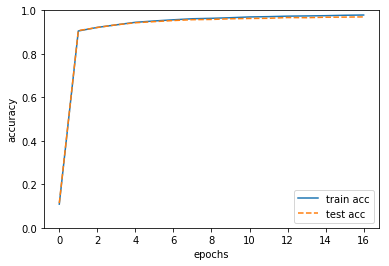

In [33]:
import matplotlib.pylab as plt

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()